# For Evaluation and Plotting of the Predictions

In [13]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from datetime import datetime, timedelta
import theano
import theano.tensor as tt
import pickle as pkl

from scipy import stats
import os

import scipy as sp
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


## Functions to load and split data (same as in other file)

In [70]:
def load_data_n_weeks(
    start,
    csv_path,
    seperator=",",
    pad = None
):
    ''' loads the data starting at a given timepoint
    Arguments:
        start (int): Days after '2020-03-05' to start the data (adapted for new date in LKOS data) NOT ENTIRELY SURE WHY WE WOULD START LATER TBH
        csv_path (str): Path to the file, inclusing the file name
        pad (int): How many days are going to be added (nan filled) at the end
    Returns:
        data (pd.df): Daframe with date as index, columns with countie IDs and values in cells.
    '''    
    

    data = pd.read_csv(csv_path, sep=seperator, encoding='iso-8859-1', index_col=0)

    data.index = [pd.Timestamp(date) for date in data.index]
    start_day = pd.Timestamp('2020-03-05') + pd.Timedelta(days=start) #changes for new start day
    data = data.loc[start_day <= data.index]

    if pad is not None:
        last_date = data.index[-1]
        extended_index = pd.date_range(last_date + pd.Timedelta(days=1),
                                       last_date + pd.Timedelta(days=pad))
        for x in extended_index:
            data = data.append(pd.Series(name=x))

    data.index = [pd.Timestamp(date) for date in data.index]

    return data

def split_data(
    data,
    train_start,
    test_start,
    post_test
):
    """
        split_data(data,data_start,train_start,test_start)

    Utility function that splits the dataset into training and testing data as well as the corresponding target values.

    Returns:
    ========
        data_train:     training data (from beginning of records to end of training phase)
        target_train:   target values for training data
        data_test:      testing data (from beginning of records to end of testing phase = end of records)
        target_test:    target values for testing data
    """

    target_train = data.loc[(train_start <= data.index)
                            & (data.index < test_start)]
    target_test = data.loc[(test_start <= data.index)
                           & (data.index < post_test)]

    data_train = data.loc[data.index < test_start]
    data_test = data

    return data_train, target_train, data_test, target_test


def sample_x_days_incidence_by_county(samples, x):
    num_sample = len(samples)
    timesteps = len(samples[0])
    counties = len(samples[0][0])
    incidence = np.empty((num_sample, timesteps - x, counties), dtype="int64")
    for sample in range(num_sample):
        for week in range(timesteps - x):
            incidence[sample][week] = np.sum(samples[sample][week : week + x], axis=0)
    return incidence

## Load the model, traces, and predictions

In [2]:
with open("model", "rb") as f:
    model = pkl.load(f)
with open("trace", "rb") as f:
    trace = pkl.load(f)
    
with open("predictions", "rb") as f:
    pred = pkl.load(f)       
with open("predictions_trend", "rb") as f:
    pred_trend = pkl.load(f)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '8804' (I am process '11124')


### Optional in-built plotting

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (54), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000244E75CF288>,
      dtype=object)

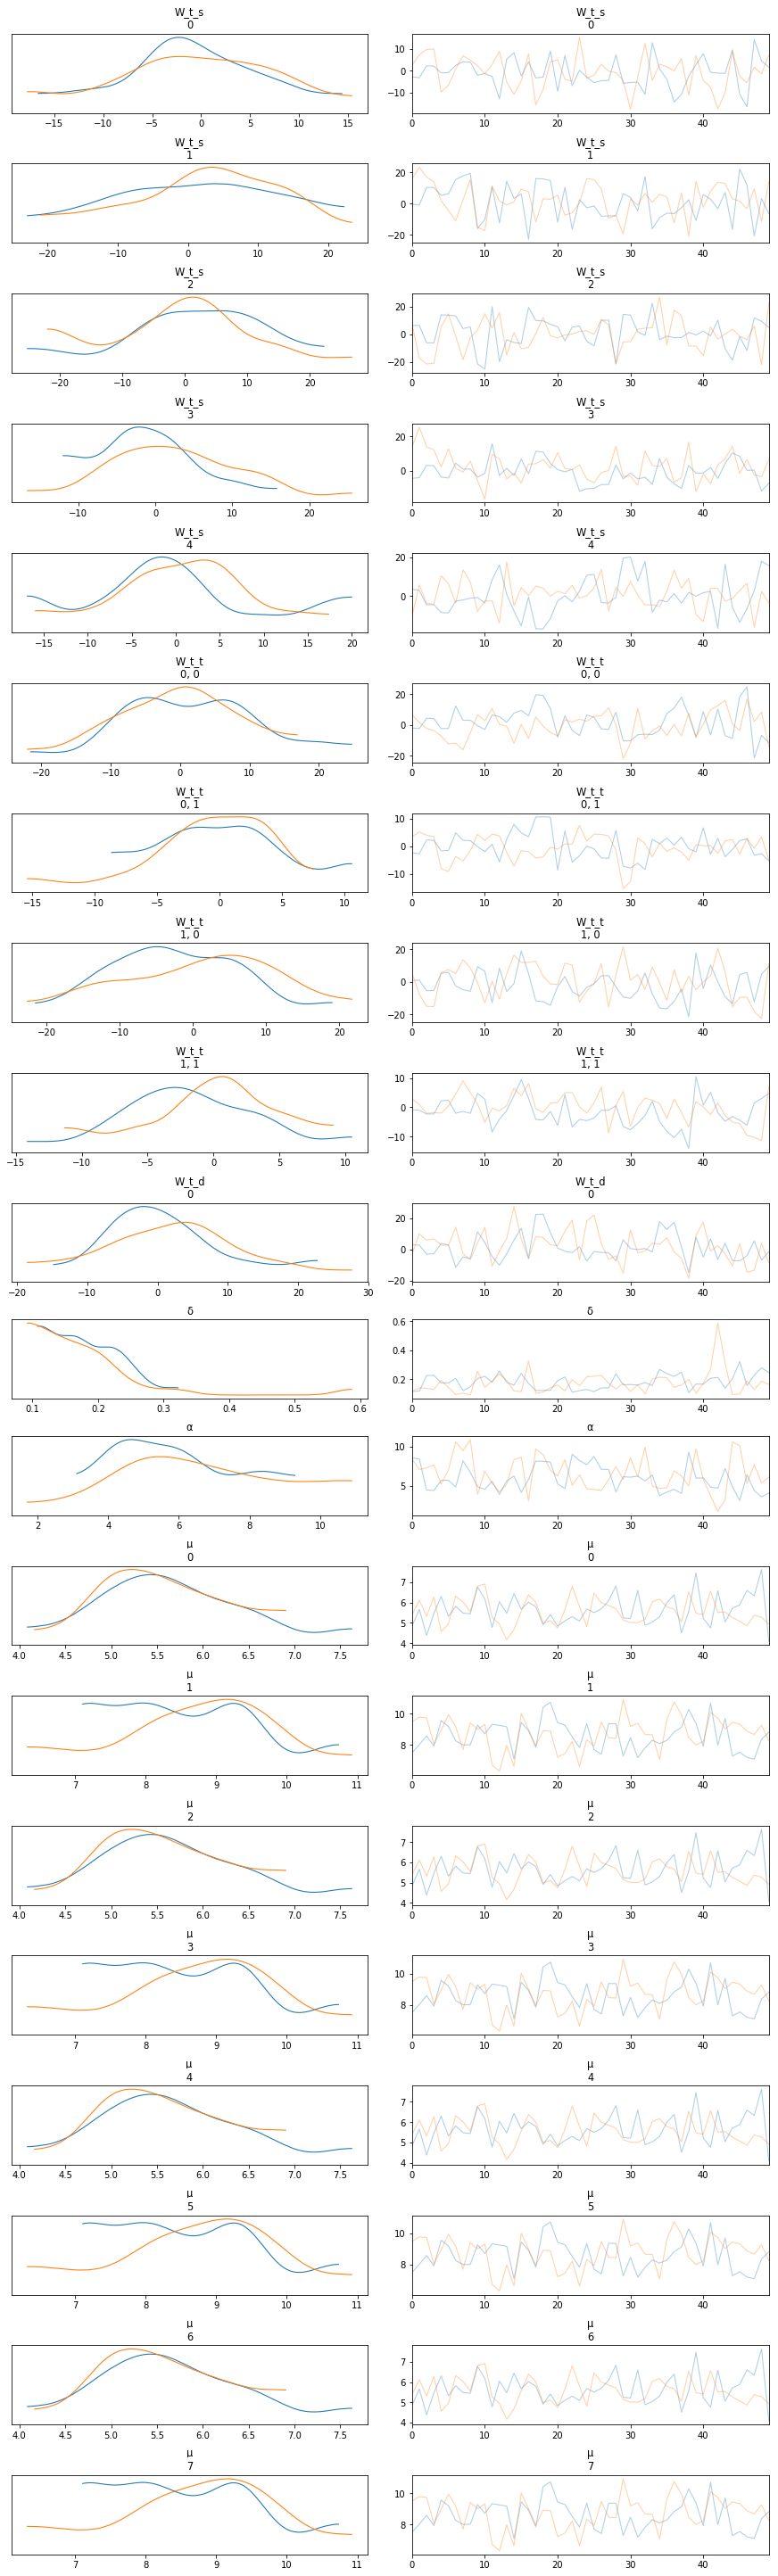

In [3]:
#1 
az.plot_trace(trace)
#2
with model:
    ppc = pm.sample_posterior_predictive(
        trace    )
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

### Load the demographic info and natural language names

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
add_info_pd = pd.read_csv(parent_directory + "\\ID_to_name.csv")
additional_info = add_info_pd.to_dict("records")
demographic = add_info_pd["demographic"].to_numpy()
nl_names = add_info_pd["NL Name"].to_numpy()

In [72]:
 # Default Values as in file where model is made
number_of_weeks = 3
days_into_future = 5
start = 180
start_date = pd.Timestamp("2020-03-20") + pd.Timedelta(days=start)

csv_path = parent_directory + "\\preprocessedLKOS.csv"

data = load_data_n_weeks(start, csv_path, pad=days_into_future)
# only take small subset to accomodate the computing power of the laptop

data = data.iloc[:,34:36]
demographic_selection = demographic[34:36]


n_weeks = 3
target_counties = data.columns
num_counties = len(target_counties) 

start_day = pd.Timestamp("2020-03-05") + pd.Timedelta(days=start)
day_0 = start_day + pd.Timedelta(days=n_weeks * 7 + 5)
day_m5 = day_0 - pd.Timedelta(days=5)
day_p5 = day_0 + pd.Timedelta(days=5)
_, target, _, _ = split_data(
    data, train_start=start_day, test_start=day_0, post_test=day_p5
)


# changed res to pred and res_trend to pred_trend
prediction_samples = np.reshape(pred["y"], (pred["y"].shape[0], -1, num_counties))
prediction_samples_mu = np.reshape(pred["μ"], (pred["μ"].shape[0], -1, num_counties))
prediction_samples_trend = np.reshape(
    pred_trend["y"], (pred_trend["y"].shape[0], -1,num_counties)
)
prediction_samples_trend_mu = np.reshape(
    pred_trend["μ"], (pred_trend["μ"].shape[0], -1,num_counties)
)


C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


### Now it starts to become unclear to me why things are happending

In [34]:
predictions_7day_inc = sample_x_days_incidence_by_county(
    prediction_samples_trend, 7
)
predictions_7day_inc_mu = sample_x_days_incidence_by_county(
    prediction_samples_trend_mu, 7
)

ext_index = pd.DatetimeIndex(
    [d for d in target.index]
    + [
        d
        for d in pd.date_range(
            target.index[-1] + timedelta(1), day_p5 - timedelta(1)
        )
    ]
)
predictions_7day_inc.shape


(100, 24, 2)

In [35]:
# changed to np.quantile, apparently this changes stuff, making the following code not working

prediction_quantiles = np.quantile(prediction_samples, [0.05, 0.25, 0.75, 0.95]) 
prediction_quantiles_trend = np.quantile(prediction_samples_trend, [0.05, 0.25, 0.75, 0.95])
prediction_quantiles_7day_inc = np.quantile(predictions_7day_inc, [0.05, 0.25, 0.75, 0.95])
print(prediction_quantiles_7day_inc) # why are all values the same? will this change with proper training?

prediction_mean = pd.DataFrame(
    data=np.mean(prediction_samples_mu, axis=0),
    index=ext_index,
    columns=target.columns,
)

prediction_q25 = pd.DataFrame(
    data=prediction_quantiles[1], index=ext_index, columns=target.columns
)
prediction_q75 = pd.DataFrame(
    data=prediction_quantiles[2], index=ext_index, columns=target.columns
)
prediction_q5 = pd.DataFrame(
    data=prediction_quantiles[0], index=ext_index, columns=target.columns
)
prediction_q95 = pd.DataFrame(
    data=prediction_quantiles[3], index=ext_index, columns=target.columns
)
prediction_q95

[27. 37. 61. 80.]


,34,35
2020-09-01,16.0,16.0
2020-09-02,16.0,16.0
2020-09-03,16.0,16.0
2020-09-04,16.0,16.0
2020-09-05,16.0,16.0
2020-09-06,16.0,16.0
2020-09-07,16.0,16.0
2020-09-08,16.0,16.0
2020-09-09,16.0,16.0
2020-09-10,16.0,16.0


In [38]:
prediction_mean_trend = pd.DataFrame(
    data=np.mean(prediction_samples_trend_mu, axis=0),
    index=ext_index,
    columns=target.columns,
)
prediction_q25_trend = pd.DataFrame(
    data=prediction_quantiles_trend[1], index=ext_index, columns=target.columns
)
prediction_q75_trend = pd.DataFrame(
    data=prediction_quantiles_trend[2], index=ext_index, columns=target.columns
)
prediction_q5_trend = pd.DataFrame(
    data=prediction_quantiles_trend[0], index=ext_index, columns=target.columns
)
prediction_q95_trend = pd.DataFrame(
    data=prediction_quantiles_trend[3], index=ext_index, columns=target.columns
)


In [74]:
prediction_mean_7day = pd.DataFrame(
    data=np.pad(
        np.mean(predictions_7day_inc_mu, axis=0),
        ((7, 0), (0, 0)), 
        "constant",
        constant_values=np.nan,
    ),
    index=ext_index,
    columns=target.columns,
)

#print(predictions_7day_inc_mu)
print("geht von den dimensionen her:\n", np.mean(predictions_7day_inc_mu, axis=0))
print("geht nicht wegen der verdammten dimensionen:\n", prediction_quantiles_7day_inc[1].astype(float))


# prediction_q75_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[2].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q5_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[0].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q95_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[3].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )

geht von den dimensionen her:
 [[38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]
 [38.72 60.16]]
geht nicht wegen der verdammten dimensionen:
 37.0


In [67]:
rki_7day = target.rolling(7).sum()

ref_date = target.iloc[-1].name
nowcast_vals = prediction_mean.loc[prediction_mean.index == ref_date]
nowcast7day_vals = prediction_mean_7day.loc[prediction_mean.index == ref_date]
rki_vals = target.iloc[-1]
rki_7day_vals = rki_7day.iloc[-1]

map_nowcast = []
map_nowcast100k = []
map_nowcast_7day = []
map_nowcast_7day100k = []
map_rki = []
map_rki100k = []
map_rki_7day = []
map_rki_7day100k = []
map_keys = []

for (county, county_id) in countyByName.items():
    rki_data = np.append(target.loc[:, county_id].values, np.repeat(np.nan, 5))
    rki_data7day = np.append(
        rki_7day.loc[:, county_id].values, np.repeat(np.nan, 5)
    )
    n_people = counties[county_id]["demographics"][("total", 2018)]

    map_nowcast.append(nowcast_vals[county_id].item())
    map_nowcast100k.append(nowcast_vals[county_id].item() / n_people * 100000)
    map_nowcast_7day.append(nowcast7day_vals[county_id].item())
    map_nowcast_7day100k.append(
        nowcast7day_vals[county_id].item() / n_people * 100000
    )
    map_rki.append(rki_vals[county_id].item())
    map_rki100k.append(rki_vals[county_id].item() / n_people * 100000)
    map_rki_7day.append(rki_7day_vals[county_id].item())
    map_rki_7day100k.append(rki_7day_vals[county_id].item() / n_people * 100000)
    map_keys.append(county_id)

    county_data = pd.DataFrame(
        {
            "Raw Prediction Mean": prediction_mean.loc[:, county_id].values,
            "Raw Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q25": prediction_q25.loc[:, county_id].values,
            "Raw Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q75": prediction_q75.loc[:, county_id].values,
            "Raw Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q5": prediction_q5.loc[:, county_id].values,
            "Raw Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5.loc[:, county_id].values, n_people), 100000,
            ),
            "Raw Prediction Q95": prediction_q95.loc[:, county_id].values,
            "Raw Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Mean": prediction_mean_trend.loc[:, county_id].values,
            "Trend Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q25": prediction_q25_trend.loc[:, county_id].values,
            "Trend Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q75": prediction_q75_trend.loc[:, county_id].values,
            "Trend Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q5": prediction_q5_trend.loc[:, county_id].values,
            "Trend Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q95": prediction_q95_trend.loc[:, county_id].values,
            "Trend Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Mean": prediction_mean_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q25": prediction_q25_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q75": prediction_q75_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q5": prediction_q5_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q95": prediction_q95_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "RKI Meldedaten": rki_data,
            "RKI 7Day Incidence": rki_data7day,
            "is_nowcast": (day_m5 <= ext_index) & (ext_index < day_0),
            "is_high": np.less(
                prediction_q95_trend.loc[:, county_id].values, rki_data
            ),
            "is_prediction": (day_0 <= ext_index),
        },
        index=ext_index,
    )
    fpath = os.path.join(output_dir, "{}.csv".format(countyByName[county]))
    county_data.to_csv(fpath)

NameError: name 'countyByName' is not defined

In [ ]:
map_df = pd.DataFrame(index=None)
map_df["countyID"] = map_keys
map_df["newInf100k"] = map_nowcast100k
map_df["7DayInf100k"] = map_nowcast_7day100k
map_df["newInf100k_RKI"] = map_rki100k
map_df["7DayInf100k_RKI"] = map_rki_7day100k
map_df["newInfRaw"] = map_nowcast
map_df["7DayInfRaw"] = map_nowcast_7day
map_df["newInfRaw_RKI"] = map_rki
map_df["7DayInfRaw_RKI"] = map_rki_7day
map_df.to_csv(os.path.join(output_dir, "map.csv"))